In [1]:
import numpy as np
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import glob
import astropy.io.fits as pf
from astropy import constants as const
import astropy.units as u
from astropy.time import Time
from astropy.timeseries import LombScargle

In [2]:
sternaam = 'BD-11_162'

# Maak een lijst van alle spectra. Data is in FITS format
datalist = glob.glob("%s/*.fits" %sternaam)
datalist.sort()


# Inlezen van de spectrale lijnen. De goflengte is in rust en in lucht (niet vacuum)
inputfile = "%s/LijnLijst.txt" %sternaam
lines,weights = np.loadtxt(inputfile,usecols=(0,1),unpack=True)

spec = pf.getdata(datalist[2])
header = pf.getheader(datalist[2])

In [3]:
# bereken de golflengte uit de data
def golflengte_grid(spec, header):

    # Lees meta-data
    ref_pix = int(header['CRPIX1'])-1   # index van de referentiepixel
    ref_val = float(header['CRVAL1'])   # ln(golflengte) van de referentiepixel
    ref_del = float(header['CDELT1'])   # breedte van de pixel in eenheid van CRVAL1
    JD = header['BJD']  # datum van de waarneming in Juliaanse dagen
    unitx = header['CTYPE1']

    numberpoints = spec.shape[0]

    # Maak een golflengtegrid aan
    wavelengthbegin = ref_val - ref_pix*ref_del
    wavelengthend = wavelengthbegin + (numberpoints-1)*ref_del
    wavelengths = np.linspace(wavelengthbegin,wavelengthend,numberpoints)
    wavelengths = np.exp(wavelengths)

    return wavelengths, JD, unitx

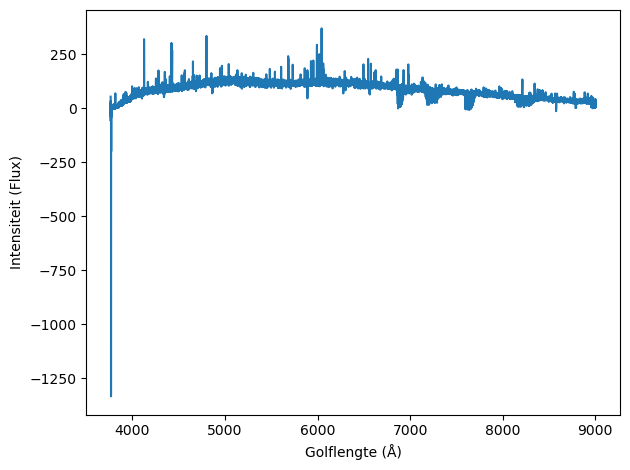

In [4]:
# krijg de data voor datalist[2]
wavelengths, JD, unitx = golflengte_grid(spec, header)

# grafiek van datalist[2]
fig, ax = plt.subplots()
ax.plot(wavelengths, spec)
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.show()

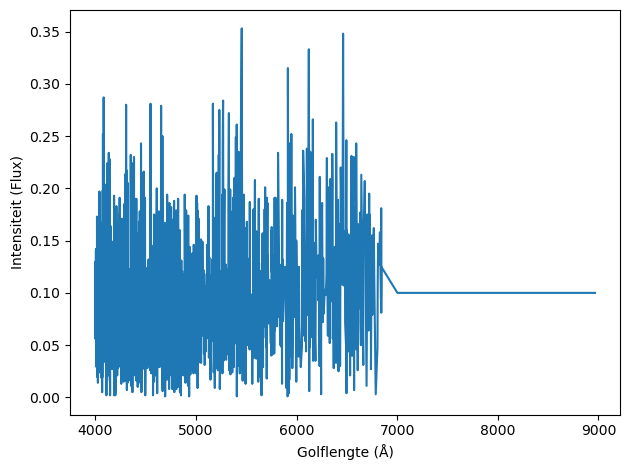

In [5]:
# grafiek van LijnLijst.txt
fig, ax = plt.subplots()
ax.plot(lines, weights)
ax.set_ylabel("Intensiteit (Flux)")
ax.set_xlabel("Golflengte (Å)")
plt.tight_layout()
plt.show()

# **Radiale Snelheid**

In [6]:
# defineer de formules om de radiale snelheid te berekenen
c = const.c
c_kms = c.value * 10**-3

def doppler(v, lambda0):
    return (v*lambda0)/c_kms + lambda0

# probeer verschillende snelheden en neem de kleinst mogelijke error marge op de lambda
def beste_v(wavelength, spec, lines, v_bereik, v_steps):
    # genereer snelheden om te testen
    v_test = np.arange(v_bereik[0], v_bereik[1] + v_steps, v_steps)
    # maak interpolatiefunctie om te snelheden te testen
    interpolate_functie = interpolate.interp1d(wavelength, spec)
    # variabelen voor de fout-kostfunctie
    wavelengthmax, wavelengthmin = wavelength.max(), wavelength.min()
    error_kost = []

    # bereken de fout voor de snelheden
    for v in v_test:
        # bereken de doppler shift
        lambda_shift = doppler(v, lines)
        # filter enkel lijnen binnen de bereik
        binnen_bereik = binnen_bereik = np.logical_and(lambda_shift >= wavelengthmin, lambda_shift <= wavelengthmax)
        lambda_shift = lambda_shift[binnen_bereik]

        # MSE
        if lambda_shift.size > 0:
            flux_observatie = interpolate_functie(lambda_shift)
            fout_mse = ((flux_observatie)**2).mean()
        else:
            fout_mse = np.inf
        error_kost.append(fout_mse)

    # beste snelheid vinden
    error_kost = np.array(error_kost)
    beste_index = np.argmin(error_kost)
    beste_v = v_test[beste_index]
    min_mse = error_kost[beste_index]

    return v_test, beste_v, error_kost

De onzekerheid door verschillende v te proberen en de beste te vinden is veel kleiner dan de systematische fouten: kalibratie, drift, ruis,...
We concluderen dus, dat de onzekerheid bepaald is door systematische fouten en niet door statistische onzekerheid van de doppler en beste_v 

In [7]:
# test de functie op een data
test = "%s/00307959_HRF_OBJ_ext_CosmicsRemoved_log_merged_cf.fits" %sternaam

test_datalist = glob.glob(test)
test_datalist.sort()
test_spec = pf.getdata(test_datalist[0])
test_header = pf.getheader(test_datalist[0])

test_wl, test_JD, test_unitx = golflengte_grid(test_spec, test_header)

In [8]:
v_t, beste_v_t, error_kost_t = beste_v(test_wl, test_spec, lines, (-50, 50), 0.1)

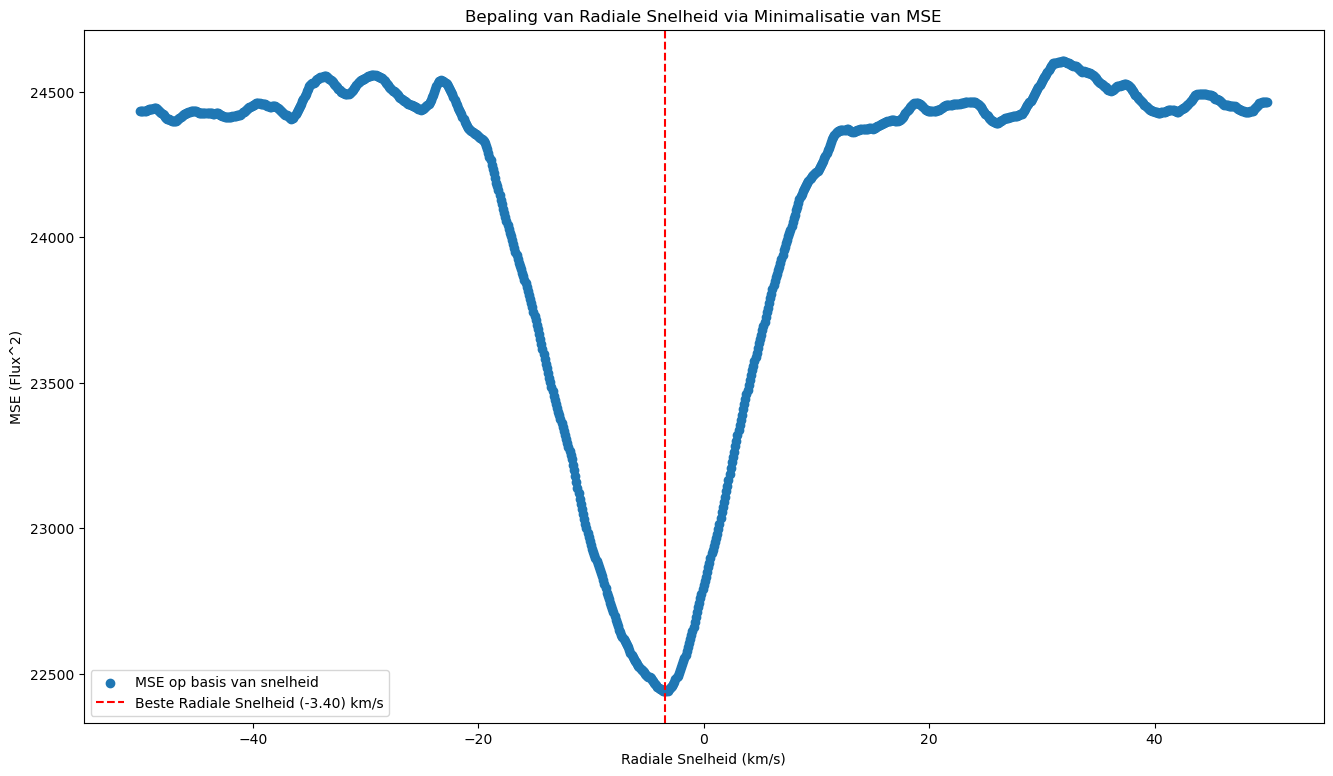

In [9]:
# grafiek van error_kort bepalend van de snelheid
fig, ax = plt.subplots(figsize = (16, 9))
ax.scatter(v_t, error_kost_t, label="MSE op basis van snelheid") # Functie error(v)
plt.axvline(float(beste_v_t), color="red", linestyle="--", label=f"Beste Radiale Snelheid ({beste_v_t:.2f}) km/s")
ax.set_xlabel("Radiale Snelheid (km/s)")
ax.set_ylabel("MSE (Flux^2)")
plt.title("Bepaling van Radiale Snelheid via Minimalisatie van MSE")
plt.legend()
plt.show()

In [10]:
# bepaal radiale snelheid voor alle gekregen data van BD-11_162
snelheid = []
gecorrigeerde_snelheid = [] # Afhankelijk waar de aarde was, verschilt de gemeten snelheid
tijd = []

# itereer over alle data
for data in datalist:
    spec = pf.getdata(data)
    header = pf.getheader(data)

    # bereken alle waarder
    wavelengths, JD, unitx = golflengte_grid(spec, header)
    beste_snelheid = beste_v(wavelengths, spec, lines, (-30, 30), 0.1)[1] # functie returnt 3 waardes en hebben de 2de nodig

    # krijg de correctie van snelheid (zie header; BVCOR)
    correctie_v = header['BVCOR']
    # zet de snelheden en tijden in lijsten'
    snelheid.append(beste_snelheid)
    gecorrigeerde_snelheid.append(beste_snelheid - correctie_v)
    tijd.append(JD)

In [11]:
# conversie van Juliaanse tijd
t = Time(tijd, format="jd", scale='tdb')
datum = t.to_datetime()

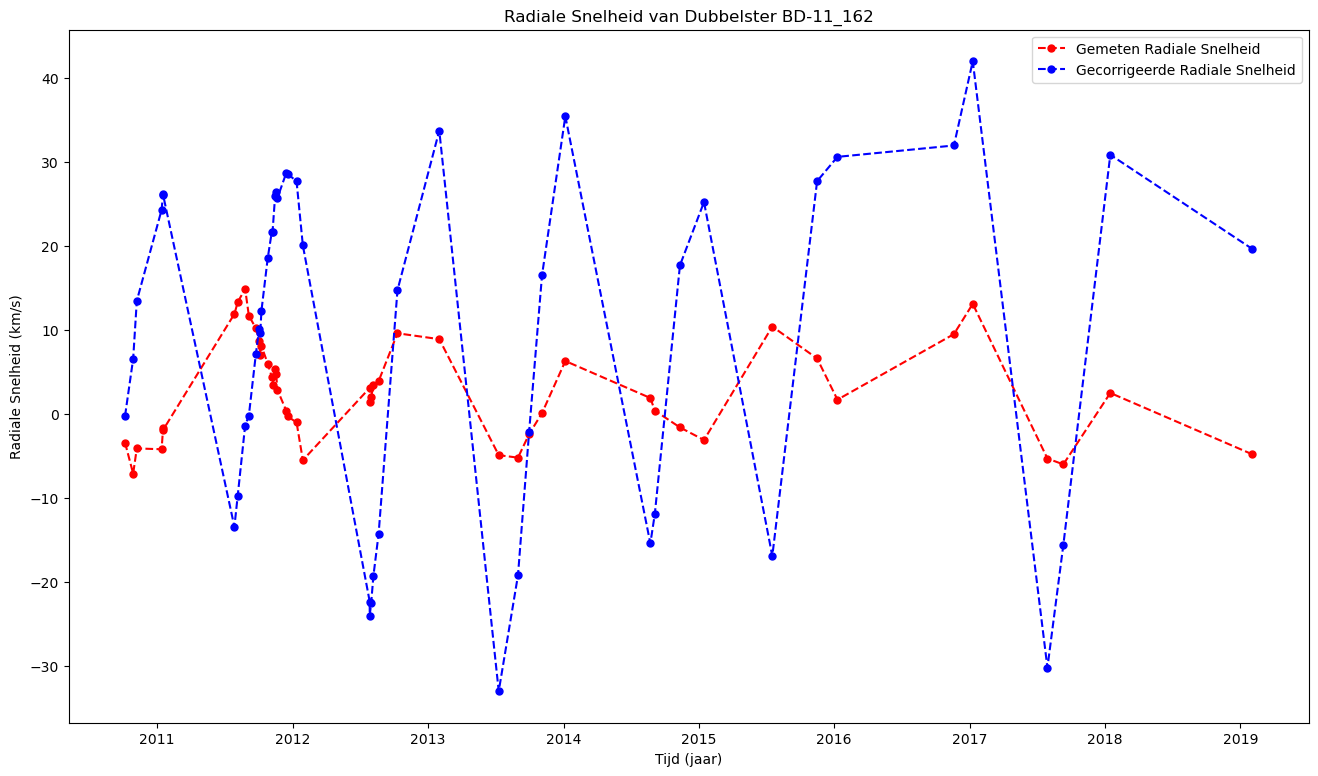

In [12]:
# plot Radiale Snelheid door de tijd heen
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(datum, snelheid, 'o--', color='red', markersize=5, label='Gemeten Radiale Snelheid')
ax.plot(datum, gecorrigeerde_snelheid, 'o--', color='blue', markersize=5, label='Gecorrigeerde Radiale Snelheid')

ax.set_xlabel("Tijd (jaar)")
ax.set_ylabel("Radiale Snelheid (km/s)")
plt.title(f'Radiale Snelheid van Dubbelster {sternaam}')
plt.legend()
plt.show()

### *Periode, Amplitude en massa voor gecorrigeerde snelheden*

In [13]:
# Bereken periode
t = np.array(tijd)
v = np.array(gecorrigeerde_snelheid)
# test periodes tussen 0.5 en 1000 dagen
frequenties = np.linspace(1/10000000.0, 1/0.5, 100000)

# bereken het periode-gram
power = LombScargle(t, v).power(frequenties)
# neem de beste frequentie (hoogste piek)
beste_freq = frequenties[np.argmax(power)]
# periode = 1/freq
P_dagen = 1.0/beste_freq
sigma_P_dagen = LombScargle(t, v).false_alarm_probability(np.max(power)) # niet zeker, online gevonden
print(f"Berekende Periode (P): {P_dagen:.4f} dagen") # zie juist onder, onzekerheid is kleiner dan 10**-20
# print(f"Berekende Periode (P): {P_dagen:.4f} +/- {sigma_P_dagen:.23f} dagen")

Berekende Periode (P): 367.6299 dagen


In [14]:
# model voor fit functie
def radiale_snelheid_fit(tijd, amplitude, t0, b):
    # v(t) = A*sin(2pi/P * (t-t0)) + b
    P = P_dagen
    return amplitude * np.sin((2*np.pi / P) * (tijd - t0)) + b

amplitude_gok = (v.max() - v.min())/2
b_gok = np.median(v)
t0_gok = t[np.argmin(v)] # Datum van het minimum

In [15]:
# calculatie
popt, pcov = curve_fit(radiale_snelheid_fit, t, v, p0=[amplitude_gok, t0_gok, b_gok])
onzekerheid = np.sqrt(np.diag(pcov))

In [16]:
# Bekijk de fit
amplitude, t0, b = popt
sigma_A, sigma_t0, sigma_b = onzekerheid

print(f"Amplitude (A): {amplitude:.4f} +/- {sigma_A:.4f} km/s")
# print(f"t0: {t0:.4f} +/- {sigma_t0:0.4f} k")
print(f"Systemische Snelheid (b): {b:.4f} +/- {sigma_b:.4f} km/s")

Amplitude (A): 28.0120 +/- 1.3383 km/s
Systemische Snelheid (b): 2.0183 +/- 1.3261 km/s


### *Niet gecorrigeerde snelheid*
ng = niet gecorrigeerd

In [17]:
# Bereken periode
t_ng = np.array(tijd)
v_ng = np.array(snelheid)
# test periodes tussen 0.5 en 1000 dagen
frequenties_ng = np.linspace(1/10000.0, 1, 100000)

# bereken het periode-gram
power_ng = LombScargle(t_ng, v_ng).power(frequenties_ng)
# neem de beste frequentie (hoogste piek)
beste_freq_ng = frequenties_ng[np.argmax(power_ng)]
# periode = 1/freq
P_dagen_ng = 1.0/beste_freq_ng
sigma_P_dagen_ng = LombScargle(t_ng, v_ng).false_alarm_probability(np.max(power_ng)) # niet zeker, online gevonden
print(f"Berekende Periode (P): {P_dagen_ng:.4f} dagen") # zie juist onder, onzekerheid is kleiner dan 10**-20
# print(f"Berekende Periode (P): {P_dagen_ng:.4f} +/- {sigma_P_dagen_ng:.28f} dagen")

Berekende Periode (P): 497.5550 dagen


In [18]:
amplitude_ng_gok = (v_ng.max() - v_ng.min())/2
b_ng_gok = np.median(v_ng)
t0_ng_gok = t_ng[np.argmin(v_ng)] # Datum van het minimum

In [19]:
# calculatie
popt_ng, pcov_ng = curve_fit(radiale_snelheid_fit, t_ng, v_ng, p0=[amplitude_ng_gok, t0_ng_gok, b_ng_gok])
onzekerheid_ng = np.sqrt(np.diag(pcov_ng))

In [20]:
# Bekijk de fit
amplitude_ng, t0_ng, b_ng = popt_ng
sigma_ng_A, sigma_ng_t0, sigma_ng_b = onzekerheid_ng

print(f"Amplitude (A_ng): {amplitude_ng:.4f} +/- {sigma_ng_A:.4f} km/s")
# print(f"t0: {t0_ng:.4f} +/- {sigma_ng_t0:0.4f} k")
print(f"Systemische Snelheid (b_ng): {b_ng:.4f} +/- {sigma_ng_b:.4f} km/s")

Amplitude (A_ng): -2.9991 +/- 1.8550 km/s
Systemische Snelheid (b_ng): 1.4612 +/- 1.3515 km/s


## Vind error hierboven voor NG popt en pcov, krijg telkens verschillende waardes

# **Massa bepaling**
### *Voor gecorrigeerde snelheid*

In [21]:
G = const.G.value
m_zon_kg = const.M_sun.value

# verander naar SI-eenheden
P_seconden = P_dagen * 60 * 60 * 24 # 60s * 60min * 24u = dag
sigma_P_seconden = sigma_P_dagen * 60 * 60 * 24
A_ms = amplitude * 10**3
sigma_A_ms = sigma_A * 10**3
m1_kg = 0.6 * m_zon_kg
sigma_m1_kg = 0.1 * m_zon_kg

# functies voor berekeningen
def massa_functie(periode_sec, K_ms):
    return (periode_sec / (2 * np.pi)) * (K_ms**3)

def nulwaarden(a, b, c, d):
    wortels = np.roots([a, b, c, d])
    reele_wortels = wortels[np.isreal(wortels)].real
    return reele_wortels

def massa2(f_M_overG, m1, hoek):
    # f(M)/sin(i)**3 = m2**3 / (m1 + m2)**2
    # neem f(m)/sini**3 als B en m1 als A
    # x**3 - Bx**2 - 2ABx - A**2B ; met x = m2
    sin_i = np.sin(hoek)
    B = f_M_overG / (sin_i**3)
    A = m1
    a = 1.0; b = -B; c = -2*A*B; d = -(A**2) * B
    return nulwaarden(a, b, c, d)

def onzekerheid(f_M, P_sec, sigma_P_sec, A_ms, sigma_A_ms):
    relatieve_onzekerheid_kwadraat = (sigma_P_sec / P_sec)**2 + 9 * (sigma_A_ms / A_ms)**2 
    
    sigma_f_M = f_M * np.sqrt(relatieve_onzekerheid_kwadraat)
    sigma_f_M_zonnemassa = sigma_f_M / G / m_zon_kg
    
    return sigma_f_M_zonnemassa

In [22]:
# berekeningen f(M)
f_M = massa_functie(P_seconden, A_ms)
f_M_overG = f_M / G
f_M_zonnemassa = f_M_overG / m_zon_kg

# onzekerheid f(M) bij 90graden
sigma_f_M_zonnemassa = onzekerheid(f_M, P_seconden, sigma_P_seconden, A_ms, sigma_A_ms)

# minimum massa m2 (bij i = 90 graden)
i_min_rad = np.deg2rad(90.0)
m2_min_kg = massa2(f_M_overG, m1_kg, i_min_rad)
m2_min_zonnemassa = m2_min_kg / m_zon_kg

# onzekerheid voor minimum massa m2
sigma_m2_min_zonnemassa = sigma_f_M_zonnemassa

print(f"Massafunctie f(M): {f_M_zonnemassa:.4f} ± {sigma_f_M_zonnemassa:.4f} M_zon")
print(f"Minimum m_2 (kg): {m2_min_zonnemassa[0]:.4f} ± {sigma_m2_min_zonnemassa:.4f} M_zon")

Massafunctie f(M): 0.8373 ± 0.1200 M_zon
Minimum m_2 (kg): 1.5890 ± 0.1200 M_zon


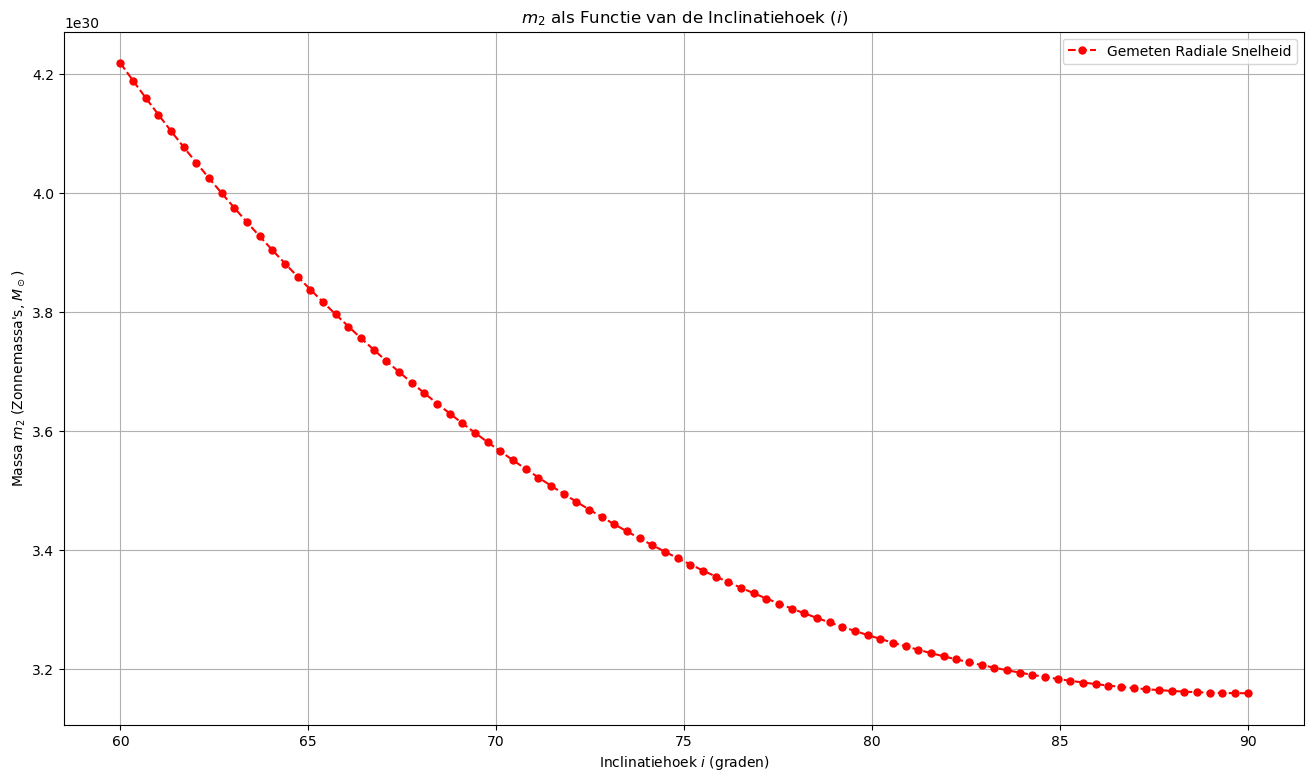

In [23]:
# Grafiek maken m2 per inclinatie
m2_zonnemassa_lijst = []
sigma_m2_zonnemassa_lijst = []

# hoeken generen voor grafiek
inclinatie_graden = np.linspace(60, 90, 90) # beginnen van 1, want kan niet delen door 0
inclinatie_rad = np.deg2rad(inclinatie_graden)

# massa's berekenen
for hoek in inclinatie_rad:
    massa2_h = massa2(f_M_overG, m1_kg, hoek)
    m2_zonnemassa_lijst.append(massa2_h)
    sigma_m2_zonnemassa_lijst.append(sigma_m2_min_zonnemassa) # nog checken, werkt niet

# maak grafiek
fig, ax = plt.subplots(figsize = (16, 9))

# Plot de data met zowel een lijn als markers (vervangt plot en errorbar)
ax.errorbar(
    inclinatie_graden,
    m2_zonnemassa_lijst,
    linestyle='--',          # Lijnstijl
    color='red',             # Kleur van de lijn
    marker="o",              # Marker-stijl
    markersize=5,            # Grootte van de markers
    label='Gemeten Radiale Snelheid'
)

# Stel de maximale y-waarde in met de variabele van de gebruiker
# max_y = 300000000000000000
# ax.set_ylim(0, max_y)

# Stel labels en titel in
plt.title('$m_2$ als Functie van de Inclinatiehoek ($i$)')
ax.set_xlabel('Inclinatiehoek $i$ (graden)')
ax.set_ylabel('Massa $m_2$ (Zonnemassa\'s, $M_\\odot$)')

# Voeg raster en legende toe
plt.grid(True)
plt.legend()

# Sla de figuur op
plt.show()